In [3]:
import os
import re
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from gensim.models import Word2Vec
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from wordcloud import WordCloud

In [4]:
file_path = 'IMDB.csv'
df = pd.read_csv(file_path, nrows=10000)
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [17]:
# import ssl
# import nltk

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download('punkt')
# nltk.download('stopwords')

In [5]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    words = word_tokenize(text.lower())

    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

df['cleaned_review'] = df['review'].apply(clean_text)

print(df[['review', 'cleaned_review']].head())

C:\Users\HP\AppData\Local\Temp\ipykernel_9432\2708760753.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  one reviewers mentioned watching 1 oz episode ...  
1  wonderful little production filming technique ...  
2  thought wonderful way spend time hot summer we...  
3  basically theres family little boy jake thinks...  
4  petter matteis love time money visually stunni...  


In [6]:
df['tokenized_review'] = df['cleaned_review'].apply(word_tokenize)

print(df[['cleaned_review', 'tokenized_review']].head())

                                      cleaned_review  \
0  one reviewers mentioned watching 1 oz episode ...   
1  wonderful little production filming technique ...   
2  thought wonderful way spend time hot summer we...   
3  basically theres family little boy jake thinks...   
4  petter matteis love time money visually stunni...   

                                    tokenized_review  
0  [one, reviewers, mentioned, watching, 1, oz, e...  
1  [wonderful, little, production, filming, techn...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, theres, family, little, boy, jake,...  
4  [petter, matteis, love, time, money, visually,...  


In [21]:
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

In [7]:
lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
df['lemmatized_review'] = df['tokenized_review'].apply(lambda tokens: [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens])
print(df[['tokenized_review', 'lemmatized_review']].head())

                                    tokenized_review  \
0  [one, reviewers, mentioned, watching, 1, oz, e...   
1  [wonderful, little, production, filming, techn...   
2  [thought, wonderful, way, spend, time, hot, su...   
3  [basically, theres, family, little, boy, jake,...   
4  [petter, matteis, love, time, money, visually,...   

                                   lemmatized_review  
0  [one, reviewer, mention, watch, 1, oz, episode...  
1  [wonderful, little, production, film, techniqu...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, there, family, little, boy, jake, ...  
4  [petter, matteis, love, time, money, visually,...  


In [8]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
print(df[['lemmatized_review', 'sentiment']].head())

                                   lemmatized_review  sentiment
0  [one, reviewer, mention, watch, 1, oz, episode...          1
1  [wonderful, little, production, film, techniqu...          1
2  [thought, wonderful, way, spend, time, hot, su...          1
3  [basically, there, family, little, boy, jake, ...          0
4  [petter, matteis, love, time, money, visually,...          1


In [9]:
df['lemmatized_review_str'] = df['lemmatized_review'].apply(lambda tokens: ' '.join(tokens))

vectorizer_bow = CountVectorizer()

X_bow = vectorizer_bow.fit_transform(df['lemmatized_review_str'])

print(f'Bag of Words matrix shape: {X_bow.shape}')

Bag of Words matrix shape: (10000, 71669)


In [10]:
vectorizer_tfidf = TfidfVectorizer()

X_tfidf = vectorizer_tfidf.fit_transform(df['lemmatized_review_str'])

print(f'TF-IDF matrix shape: {X_tfidf.shape}')

TF-IDF matrix shape: (10000, 71669)


In [11]:
model_w2v = Word2Vec(sentences=df['lemmatized_review'], vector_size=100, window=5, min_count=1, workers=4)

print(model_w2v.wv['movie'])

def get_avg_word2vec(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['w2v_vector'] = df['lemmatized_review'].apply(lambda tokens: get_avg_word2vec(tokens, model_w2v))

print(df[['lemmatized_review', 'w2v_vector']].head())

[-0.9954931   0.8116377   0.06641964  0.93189585  0.12788558 -1.3001791
  1.7352822   2.007763   -0.9176369  -0.27240145 -0.249672   -1.1849881
 -1.1563796   1.2878613   0.20906813  0.25887915  0.5180085   0.49925137
 -0.90598565 -1.8591479   1.5884137   0.11257131  1.3674636  -0.67835367
  1.3209063  -0.8050103  -1.3977739  -0.71377224 -1.9170043  -0.07032675
  0.65850544  0.00759484  1.5757219  -2.3182166  -0.7466331   0.798884
  1.1528533   0.26752532  0.79033613 -0.35347897 -0.23373501 -0.83322215
 -0.52568007  0.6786846   1.0985258   0.37126836  0.08559901  0.32180244
  0.86808383  0.38438472  0.5560336  -0.38222027 -0.74918693  0.4284661
  0.3437457   0.26219758  1.558477   -0.15054105 -0.820134    0.25653228
  0.0836824   0.35903648  0.5367398  -0.4847703  -1.169949    1.2649583
  0.89010596  1.0085092  -0.69256306  0.72356623  0.02472645  0.86463314
  1.0642214  -0.49999842  1.62657    -0.09202198  0.4858764   0.63851154
 -0.97006714 -0.7045341  -1.3315482  -0.55869603 -0.51609

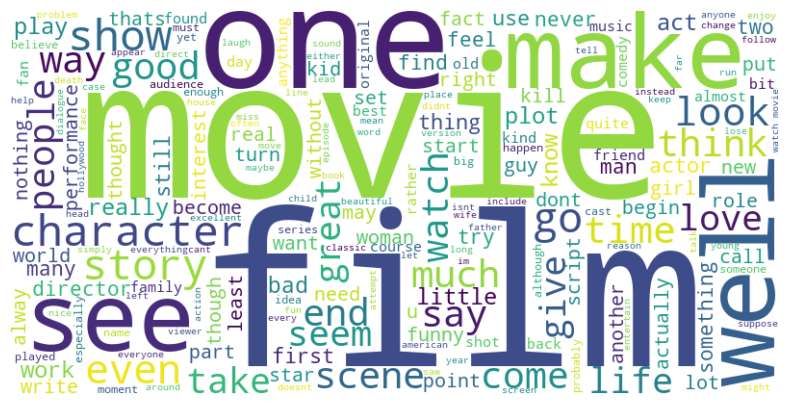

In [12]:
all_words = ' '.join([' '.join(tokens) for tokens in df['lemmatized_review']])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

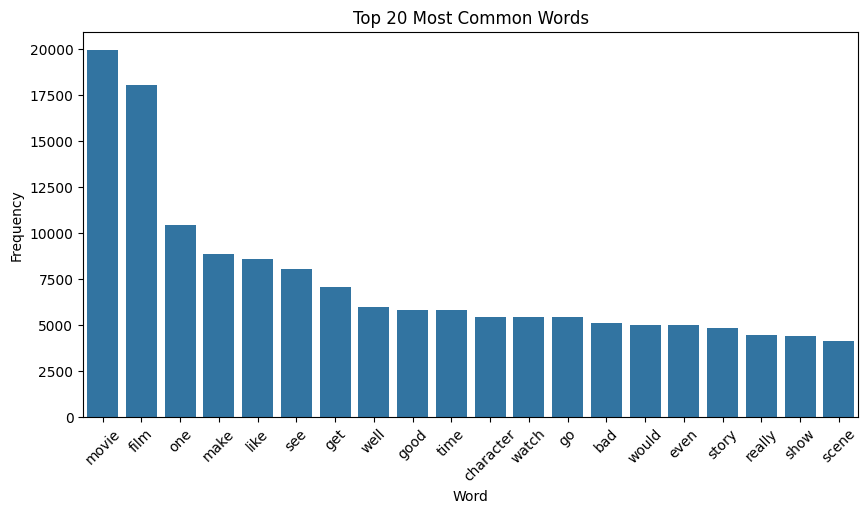

In [13]:
all_words_list = [word for tokens in df['lemmatized_review'] for word in tokens]

freq_dist = Counter(all_words_list)

most_common_words = freq_dist.most_common(20)

freq_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 5))
sns.barplot(x='Word', y='Frequency', data=freq_df)
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Words')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_9432\2667726907.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


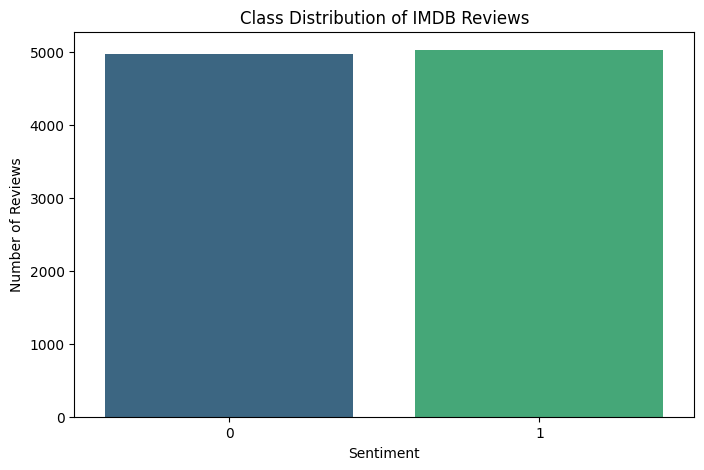

sentiment
1    5028
0    4972
Name: count, dtype: int64


In [14]:
class_distribution = df['sentiment'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Class Distribution of IMDB Reviews')
plt.show()

print(class_distribution)

In [15]:
X = df['lemmatized_review'].apply(lambda x: ' '.join(x))  # Join tokens back into a single string for each review
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training set size: {len(X_train)}')
print(f'Testing set size: {len(X_test)}')

Training set size: 8000
Testing set size: 2000


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear'),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100)
}

for name, model in models.items():
    print(f'Training {name}...')
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    print(f'{name} accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))
    print('-'*60)

In [ ]:
param_grids = {
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'max_iter': [100, 200, 500, 1000]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

best_models = {}
for name, model in models.items():
    print(f'Tuning hyperparameters for {name}...')
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_tfidf, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f'Best parameters for {name}: {grid_search.best_params_}')
    print(f'Best cross-validated accuracy for {name}: {grid_search.best_score_:.4f}')
    print('-'*60)

for name, model in best_models.items():
    print(f'Evaluating {name} with best hyperparameters...')
    y_pred = model.predict(X_test_tfidf)
    
    print(f'{name} accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))
    print('-'*60)

In [ ]:
for name, model in best_models.items():
    print(f'Evaluating {name} with best hyperparameters...')
    y_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name} Accuracy: {accuracy:.4f}')
    print(f'{name} Precision: {precision:.4f}')
    print(f'{name} Recall: {recall:.4f}')
    print(f'{name} F1-Score: {f1:.4f}')
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='viridis')
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    
    print('-'*60)

In [ ]:
voting_clf = VotingClassifier(estimators=[
    ('nb', best_models['Naive Bayes']),
    ('svm', best_models['SVM']),
    ('lr', best_models['Logistic Regression']),
    ('rf', best_models['Random Forest']),
    ('gb', best_models['Gradient Boosting'])
], voting='hard')

voting_clf.fit(X_train_tfidf, y_train)

y_pred = voting_clf.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Ensemble Model Accuracy: {accuracy:.4f}')
print(f'Ensemble Model Precision: {precision:.4f}')
print(f'Ensemble Model Recall: {recall:.4f}')
print(f'Ensemble Model F1-Score: {f1:.4f}')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_clf.classes_)
disp.plot(cmap='viridis')
plt.title('Ensemble Model Confusion Matrix')
plt.show()

In [ ]:
os.makedirs('saved_models', exist_ok=True)

for name, model in best_models.items():
    model_filename = f'saved_models/{name.replace(" ", "_").lower()}_model.pkl'
    joblib.dump(model, model_filename)
    print(f'Saved {name} model to {model_filename}')

ensemble_model_filename = 'saved_models/ensemble_model.pkl'
joblib.dump(voting_clf, ensemble_model_filename)
print(f'Saved ensemble model to {ensemble_model_filename}')
joblib.dump(vectorizer, 'saved_models/tfidf_vectorizer.pkl')